In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


In [2]:

real = "C:\\Users\\91857\\Desktop\\ml_practice\\real-and-fake-face-detection-master\\dataset\\training\\training_real"
fake = "C:\\Users\\91857\\Desktop\\ml_practice\\real-and-fake-face-detection-master\\dataset\\training\\training_fake"


#we're creating a list of real and fake images
real_path = os.listdir(real)
print (real_path[0:10])
fake_path = os.listdir(fake)
print (fake_path[0:10])

['real_00001.jpg', 'real_00002.jpg', 'real_00003.jpg', 'real_00004.jpg', 'real_00005.jpg', 'real_00006.jpg', 'real_00007.jpg', 'real_00008.jpg', 'real_00009.jpg', 'real_00010.jpg']
['easy_100_1111.jpg', 'easy_101_0010.jpg', 'easy_102_0101.jpg', 'easy_103_1111.jpg', 'easy_104_1000.jpg', 'easy_105_1100.jpg', 'easy_106_0011.jpg', 'easy_107_1011.jpg', 'easy_108_1111.jpg', 'easy_109_1111.jpg']


In [3]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(100,100))

    return image[...,::-1]

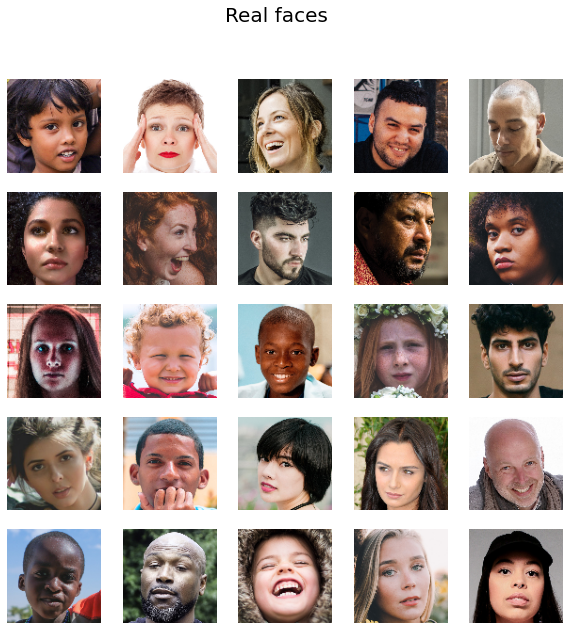

In [4]:

fig = plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.imshow(load_img(real +"\\"+ real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

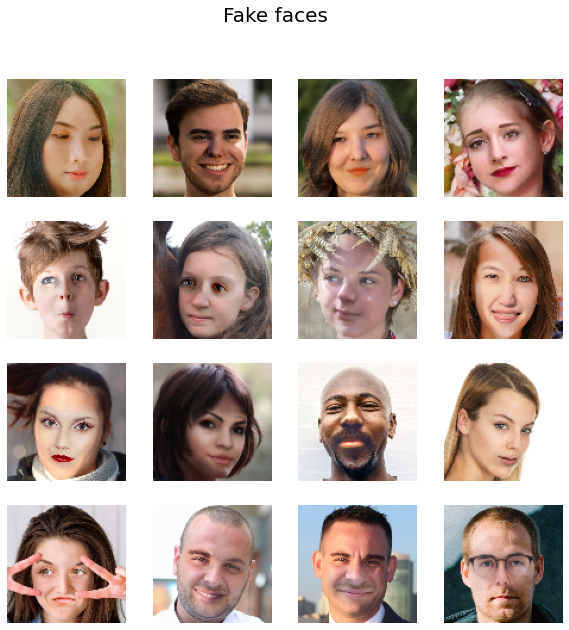

In [5]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake +"\\"+ fake_path[i]), cmap='gray')
    plt.suptitle("Fake faces",fontsize=20)
    plt.axis('off')

plt.show()

In [6]:
img_size = int(128)

def create_training_data():
    training_data = []
    for img in tqdm(real_path[:865]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        training_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[:768]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(image), np.array(label)])
        
    
    for img in tqdm(real_path[:865]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        training_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[:768]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(image), np.array(label)])
        
    
        
    shuffle(training_data) #shuffle data for more variability in training set
    return(training_data)

def create_test_data():
    test_data = []
    for img in tqdm(real_path[866:]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        test_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[769:]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        test_data.append([np.array(image), np.array(label)])
        
    
    for img in tqdm(real_path[866:]):
        path = os.path.join(real, img)
        label = [1] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        test_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[769:]):
        path = os.path.join(fake, img)
        label = [0] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        test_data.append([np.array(image), np.array(label)])
        
    
        
    shuffle(test_data) #shuffle data for more variability in training set
    return(test_data)



    

#total training data with fake + real images, along with labels, converted to a grayscale
#adding data 2x to populate model more. Doing this bumped up accuracy from 60 to 70%

train_data = create_training_data()
test_data = create_test_data()


100%|███████████████████████████████████████████████████████████████████████████████| 658/658 [00:04<00:00, 153.99it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [7]:
X = []
y = []

for i in train_data:
    X.append(i[0])
    y.append(i[1])

    
#print(X[0].reshape(-1, 50, 50, 1))
X = np.array(X).reshape(-1, img_size, img_size, 1)


#divide by 255 to squish values to 0 - 1
X = X/255.0
y = np.array(y)

#we made X and y np arrays to be able to feed into the model
test_pic = []
test_lab = []


for i in test_data:
    test_pic.append(i[0])
    test_lab.append(i[1])
        
#print(X[0].reshape(-1, 50, 50, 1))
test_pic = np.array(test_pic).reshape(-1, img_size, img_size, 1)


#divide by 255 to squish values to 0 - 1
test_pic = test_pic/255.0
test_lab = np.array(test_lab)

In [8]:

print(X.shape[1:])
print(X.shape[:])
#checking shape of array to confirm
print(len(y))

(128, 128, 1)
(2874, 128, 128, 1)
2874


In [10]:
from keras.layers import LSTM

In [54]:

model = Sequential()

#\model.add(Flatten()) 

model.add(Flatten()) 
#model.add(Dense(128, input_shape=(128,128,1)))
model.add(LSTM(32,input_shape=(1,16384)))
#model.add(Conv2D(128,(3,3), input_shape=X.shape[1:])) 
#model.add(Activation("relu")) 
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(32,(3,3))) 
#model.add(Activation("relu")) 
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(.5))
#
#model.add(Conv2D(32,(2,2))) 
#model.add(Activation("relu")) 
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(32,(2,2))) 
#model.add(Activation("relu")) 
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Dropout(0.5))

model.add(Flatten()) 
model.add(Dense(128))

model.add(Dense(1)) 
model.add(Activation("sigmoid"))

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

history = model.fit(X, y, batch_size = 16, epochs = 30, verbose = 1, validation_split = 0.2)


# test_loss, test_accuracy = model.evaluate(test_data, test_lab)

Epoch 1/30


ValueError: in user code:

    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\91857\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\91857\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\91857\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\sequential.py:383 call
        outputs = layer(inputs, **kwargs)
    C:\Users\91857\anaconda3\lib\site-packages\keras\layers\recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\91857\anaconda3\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer lstm_37 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 16384)


In [ ]:
yhat_probs = model.predict(test_pic, verbose=1)
# predict crisp classes for test set
yhat_classes = model.predict_classes(test_pic, verbose=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_lab, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_lab, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_lab, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_lab, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(test_lab, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(test_lab, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_lab, yhat_classes)
print(matrix)


average_precision = average_precision_score(test_lab, yhat_classes)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(yhat_classes, test_pic, test_lab)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))


In [ ]:
def give_img(path):
    img_size = int(128)
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size, img_size))
    return img.reshape(-1, img_size, img_size, 1)

pred = model2.predict(test_pic)
pred = pred.round().astype(int)
print(pred[:10])
print(test_lab[:10])

count = 0

for i in pred:
    if pred[i] == test_lab[i]:
            count += 1
            
print(count)
print()

In [ ]:
print(history.history.keys())
print(history.history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()